<a href="https://colab.research.google.com/github/lsteffenel/RT0902-IntroML/blob/main/15-Chicago_crime_data_on_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chicago crime dataset analysis
---

Ce notebook permet d'appliquer un peu de vos connaissances à la découverte d'un vrai dataset.

Vous allez effectuer :
 * Lecture, transformation et requêtage avec Apache Spark.
 * Parfois, transformer les données en Pandas pour une meilleure visualisation.


---

## Quelques Import



Import de Pandas et Matplotlib

In [1]:
## standard imports
import pandas as pnd
import matplotlib.pyplot as plt

Spark imports

In [2]:
import os
memory = '8g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [3]:
## spark imports
from pyspark.sql import Row, SparkSession
import pyspark.sql.functions as pyf

spark = SparkSession.builder.master("local[1]").appName("RT0902").getOrCreate()

---
## Dataset
Les données originales viennent de Kaggle (https://www.kaggle.com/djonafegnem/chicago-crime-data-analysis)

On trouve une liste de crimes registrés par le département de police de Chicago.

Le dataset "réel" contient 4 fichiers pour des crimes allant de 2001 à 2017.
Comme le traitement de ces fichiers est long et demandeur en ressources, vous allez d'abord travailler avec un fichier réduit, qui ne contient que des données de 2001.

Une fois votre code "validé", vous pouvez l'utiliser sur le cloud pour traiter l'ensemble de fichiers de la police.

Ci-dessous vous trovez une description des différents champs des fichiers

In [4]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''

In [5]:
def entry_dic(line):
    """
    Convert a header - description line into a single dictionary that holds the original header as 'title', a corresponding field name as 'header', and a description.
    """
    pair = line.split(' - ')
    return {'title': pair[0], 'description': pair[1], 'header': pair[0].lower().replace(' ', '_')}

Créer une liste de titres à partir de la fonction précédente

In [6]:
header_dics = list(map(entry_dic, list(filter(lambda l: l != '', content_cols.split('\n')))))

In [7]:
header_dics[:2]

[{'title': 'ID',
  'description': 'Unique identifier for the record.',
  'header': 'id'},
 {'title': 'Case Number',
  'description': 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.',
  'header': 'case_number'}]

### Données

Les données seront téléchargées et stockées dans `./data/`. Ce sont des fichiers .CSV.


In [8]:
!mkdir data

In [9]:
!gsutil -m cp -r gs://angelo_crime_data/*.csv ./data

Copying gs://angelo_crime_data/Chicago_Crimes_2005_to_2007.csv...
Copying gs://angelo_crime_data/Chicago_Crimes_2001_to_2004.csv...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://angelo_crime_data/Chicago_Crimes_2008_to_2011.csv...
Copying gs://angelo_crime_data/Chicago_Crimes_2012_to_2017.csv...
Copying gs://angelo_crime_data/mini_data.csv...
/ [5/5 files][  2.0 GiB/  2.0 GiB] 100% Done  81.1 MiB/s ETA 00:00:00           
Operation completed over 5 objects/2.0 GiB.                                      


In [10]:
!ls -lh data/

total 2.0G
-rw-r--r-- 1 root root 454M Mar  9 20:07 Chicago_Crimes_2001_to_2004.csv
-rw-r--r-- 1 root root 450M Mar  9 20:07 Chicago_Crimes_2005_to_2007.csv
-rw-r--r-- 1 root root 647M Mar  9 20:07 Chicago_Crimes_2008_to_2011.csv
-rw-r--r-- 1 root root 350M Mar  9 20:07 Chicago_Crimes_2012_to_2017.csv
-rw-r--r-- 1 root root 130M Mar  9 20:07 mini_data.csv


---
## Lecture des données

Avec l'opération `csv read` de spark, nous allons lire et parser les fichiers. Le résultat sera un seul DataFrame :

In [11]:
#df = spark.read.csv('./data/Chicago_*.csv', inferSchema=True, header=True)
df = spark.read.csv('./data/mini_data.csv', inferSchema=True, header=True)

Note : ce qui prend vraiment le temps est la découverte du schéma : on n'a pas tellement de lignes, après tout.

In [12]:
# Ce DataFrame sera mis en cache (gardé en mémoire) car il sera utilisé plusieurs fois.
#df = df.cache()

In [13]:
# Affichage du schéma (structure) du dataframe
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- case_number: string (nullable = true)
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: integer (nullable = true)
 |-- district: double (nullable = true)
 |-- ward: double (nullable = true)
 |-- community_area: double (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



### Différences entre Pandas et Spark
Pandas a des opérations telles que `info()` et `describe()`. Dans Spark, on n'a que `describe()`, qui n'est pas comparable à celle de Pandas : il affiche plutôt le type des données, un peu comme `printSchema()`.

In [14]:
df.describe()

DataFrame[summary: string, _c0: string, id: string, case_number: string, date: string, block: string, iucr: string, primary_type: string, description: string, location_description: string, beat: string, district: string, ward: string, community_area: string, fbi_code: string, x_coordinate: string, y_coordinate: string, year: string, updated_on: string, latitude: string, longitude: string, location: string]

Certaines lignes de n'ont aucune valeur déclarée à la colonne `location_description` . C'est le moment de les supprimer.

Pour cela, nous allons filtrer les entrées vides ('') en utilisant la fonction **`Dataset.filter`**.

In [15]:
df = df.filter(df['location_description'] != '')

Un petit aperçu du début du dataframe :

In [16]:
df.show(n=3, truncate=False)

+---+-------+-----------+----------------------+-----------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|_c0|id     |case_number|date                  |block                  |iucr|primary_type              |description                  |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on            |latitude    |longitude    |location                     |
+---+-------+-----------+----------------------+-----------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|0  |4791194|HM403711 

On a quand même plus de 560 mille entrées !! 😵

In [17]:
print(df.count())

568515


---
## Comprendre les données

### Types de Crime

On veut connaître combien de types de crime (catégories) existent dans le fichier.

In [18]:
# crime types
crime_type_groups = df.groupBy('primary_type').count()

In [19]:
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)

Jusqu'à ici ça a été rapide : Spark fait une exécution *lazy*, i.e., il n'a fait qu'enregistrer les *transformations* à applier. Il attendra pour lancer l'exécution uniquement lorsqu'une *action* est demandée (par exemple, afficher le résultat).

Dans la ligne suivante on demande le nombre total de lignes, mais en fait il va appliquer les modifications, faire le filtrage, etc. Sur un grand dataset, ça peut prendre pas mal de temps (d'où l'intérêt de distribuer le travail entre plusieurs machines).



La commande suivante affiche les 20 types de crime les plus fréquents :

In [20]:
crime_type_counts.show(truncate=False)

+--------------------------+------+
|primary_type              |count |
+--------------------------+------+
|THEFT                     |115887|
|BATTERY                   |108600|
|CRIMINAL DAMAGE           |65050 |
|NARCOTICS                 |59900 |
|ASSAULT                   |36439 |
|OTHER OFFENSE             |35538 |
|MOTOR VEHICLE THEFT       |32082 |
|BURGLARY                  |30218 |
|ROBBERY                   |21504 |
|DECEPTIVE PRACTICE        |17320 |
|CRIMINAL TRESPASS         |15869 |
|PROSTITUTION              |6977  |
|WEAPONS VIOLATION         |5028  |
|PUBLIC PEACE VIOLATION    |3167  |
|OFFENSE INVOLVING CHILDREN|2619  |
|SEX OFFENSE               |2616  |
|CRIM SEXUAL ASSAULT       |2131  |
|LIQUOR LAW VIOLATION      |1861  |
|HOMICIDE                  |1334  |
|ARSON                     |1177  |
+--------------------------+------+
only showing top 20 rows



On peut faire un affichage plus propre (et d'autres opérations) en transformant ce dataframe en Pandas :


In [21]:
counts_pddf = crime_type_counts.toPandas()

In [22]:
counts_pddf.head(10)

,primary_type,count
0,THEFT,115887
1,BATTERY,108600
2,CRIMINAL DAMAGE,65050
3,NARCOTICS,59900
4,ASSAULT,36439
5,OTHER OFFENSE,35538
6,MOTOR VEHICLE THEFT,32082
7,BURGLARY,30218
8,ROBBERY,21504
9,DECEPTIVE PRACTICE,17320


Ce dataset Pandas peut être utilisé pour une petite visualisation :

<Axes: ylabel='primary_type'>

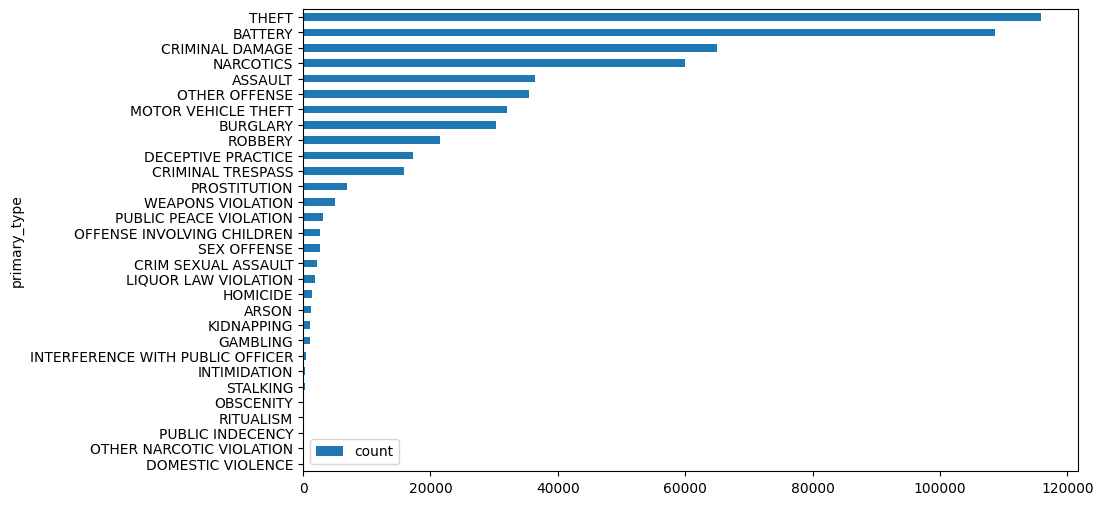

In [23]:
plt.rcParams["figure.figsize"] = [10, 6]

counts_pddf.sort_values('count').plot(kind='barh', x='primary_type', y='count')

### Convertir les dates

**Si vous avez été attentif**, vous avez remarqué que les colonnes avec des dates ont été lues comme du texte simple :

In [24]:
df.describe()

DataFrame[summary: string, _c0: string, id: string, case_number: string, date: string, block: string, iucr: string, primary_type: string, description: string, location_description: string, beat: string, district: string, ward: string, community_area: string, fbi_code: string, x_coordinate: string, y_coordinate: string, year: string, updated_on: string, latitude: string, longitude: string, location: string]

---
En effet, le schéma montrait que le champ `date` était de type `string`, ce qui n'est pas très utile.

Nous allons convertir ces dates au format timestamp.

Nous allons changer ce format afin de le lire sous la forme '02/23/2006 09:06:22 PM' , c'est à dire **`'MM/dd/yyyy hh:mm:ss a'`** (format américain).

On va aussi rajouter une colonne `month` qui indique le premier jour du mois, sans l'heure.

In [31]:
from pyspark.sql.functions import to_timestamp, hour, trunc
# d'abord, on convertit 'date' avec to_timestamp() et on enregistre cette valeur dans 'date_time'
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))
# ensuite, on crée une colonne 'month' à partir de 'datetime')
df = df.withColumn('month', trunc('date_time', 'month')) #adding a month column to be able to view stats on a monthly basis

In [27]:
df.select(['date','date_time', 'month'])\
  .show(n=20, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|01/01/2001 11:00:00 AM|2001-01-01 11:00:00|2001-01-01|
|01/01/2001 12:00:00 AM|2001-01-01 00:00:00|2001-01-01|
|01/01/2001 12:00:00 AM|2001-01-01 00:00:00|2001-01-01|
|06/16/2001 08:00:00 AM|2001-06-16 08:00:00|2001-06-01|
|06/01/2001 08:00:00 AM|2001-06-01 08:00:00|2001-06-01|
|07/25/2001 10:00:00 AM|2001-07-25 10:00:00|2001-07-01|
|06/23/2001 08:00:00 PM|2001-06-23 20:00:00|2001-06-01|
|01/01/2001 12:00:00 AM|2001-01-01 00:00:00|2001-01-01|
|05/01/2001 12:01:00 AM|2001-05-01 00:01:00|2001-05-01|
|10/01/2001 12:01:00 AM|2001-10-01 00:01:00|2001-10-01|
|01/01/2001 12:01:00 AM|2001-01-01 00:01:00|2001-01-01|
|10/01/2001 08:00:00 AM|2001-10-01 08:00:00|2001-10-01|
|11/09/2001 09:00:00 AM|2001-11-09 09:00:00|2001-11-01|
|05/30/2001 03:00:00 PM|2001-05-30 15:00:00|2001-05-01|
|06/01/2001 12:00:00 PM|2001-06-01 12:00:00|2001

### Combien d'arrestations ?

Pas tous les crimes donnent lieu à des arrestations.
Grâce à `groupBy`, nous allons afficher le nombre d'arrestations par mois (et le nombre de crimes sans arrestations).

In [28]:
# On peut utiliser la colonne month pour affiche les quantités d'arrestations au fil des années, groupées par mois :
type_arrest_date = df.groupBy(['arrest', 'month'])\
                     .count()\
                     .orderBy(['month', 'count'], ascending=[True, False])
print()
type_arrest_date.show(truncate=False)


+------+----------+-----+
|arrest|month     |count|
+------+----------+-----+
|false |2001-01-01|50720|
|true  |2001-01-01|24275|
|false |2001-02-01|44655|
|true  |2001-02-01|21633|
|false |2001-03-01|37706|
|true  |2001-03-01|15413|
|false |2001-04-01|28258|
|true  |2001-04-01|11908|
|false |2001-05-01|29796|
|true  |2001-05-01|12080|
|false |2001-06-01|29854|
|true  |2001-06-01|11969|
|false |2001-07-01|32838|
|true  |2001-07-01|11963|
|false |2001-08-01|31864|
|true  |2001-08-01|12251|
|false |2001-09-01|30162|
|true  |2001-09-01|11440|
|false |2001-10-01|31168|
|true  |2001-10-01|11963|
+------+----------+-----+
only showing top 20 rows



### Comment le nombre d'arrestations a évolué sur l'année ?

Pour l'afichage, nous allons encore une fois transformer notre dataset en Pandas. On transforme `type_arrest_date`, puis on utilise matplotlib pour l'affichage.

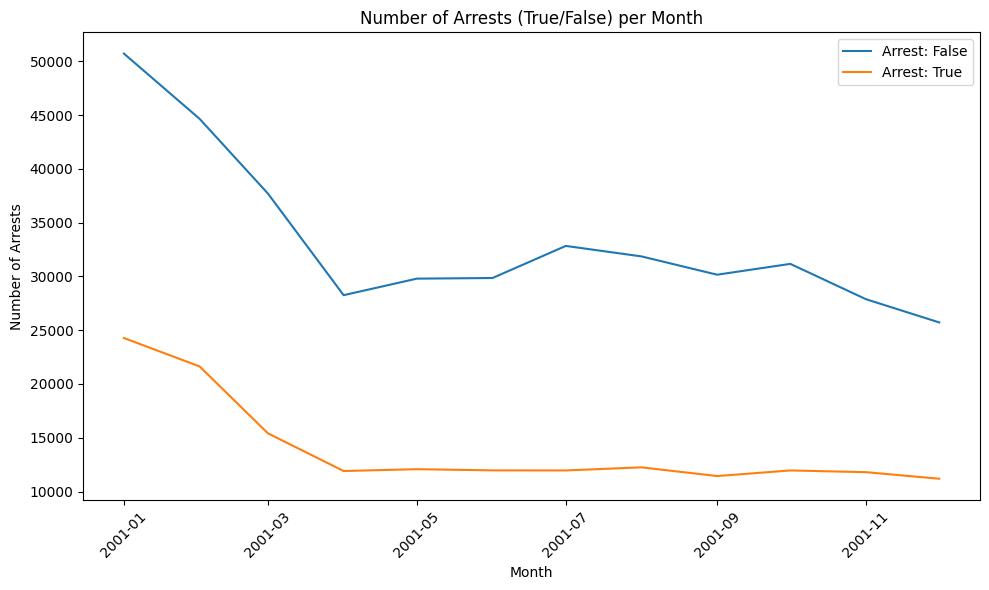

In [29]:
# prompt: à partir de type_arrest_date, générer un graphique matplotlib affichant le nombre arrests true et false, par mois

import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
type_arrest_date_pandas = type_arrest_date.toPandas()

# Create the plot
plt.figure(figsize=(10, 6))
for arrest_status in type_arrest_date_pandas['arrest'].unique():
    subset = type_arrest_date_pandas[type_arrest_date_pandas['arrest'] == arrest_status]
    plt.plot(subset['month'], subset['count'], label=f'Arrest: {arrest_status}')

plt.xlabel('Month')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests (True/False) per Month')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### À quel moment de la journée les criminels sont plus actifs ?

Ici c'est à vous de refaire le même type d'opération. Je vais juste vous montrer comment créer une colonne avec les heures.

In [32]:
# Extract the "hour" field from the date into a separate column called "hour"
df_hour = df.withColumn('hour', hour(df['date_time']))

In [33]:
# Derive a data frame with crime counts per hour of the day:
hourly_count = df_hour.groupBy(['primary_type', 'hour']).count()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

In [34]:
hourly_count_pddf = hourly_count.toPandas()
hourly_total_count_pddf = hourly_total_count.toPandas()

In [35]:
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')
hourly_total_count_pddf = hourly_total_count_pddf.sort_values(by='hour')

In [36]:
hourly_count_pddf.head(10)

,primary_type,hour,count
320,LIQUOR LAW VIOLATION,0,83
339,NARCOTICS,0,1865
580,MOTOR VEHICLE THEFT,0,2026
151,ARSON,0,109
626,ASSAULT,0,1140
298,HOMICIDE,0,80
46,THEFT,0,5741
292,ROBBERY,0,1207
241,STALKING,0,8
584,WEAPONS VIOLATION,0,311


In [37]:
hourly_total_count_pddf.head(10)

,hour,sum(count)
22,0,28860
2,1,18603
21,2,15247
6,3,12069
13,4,9211
8,5,7368
4,6,7993
16,7,11827
14,8,18115
11,9,22218


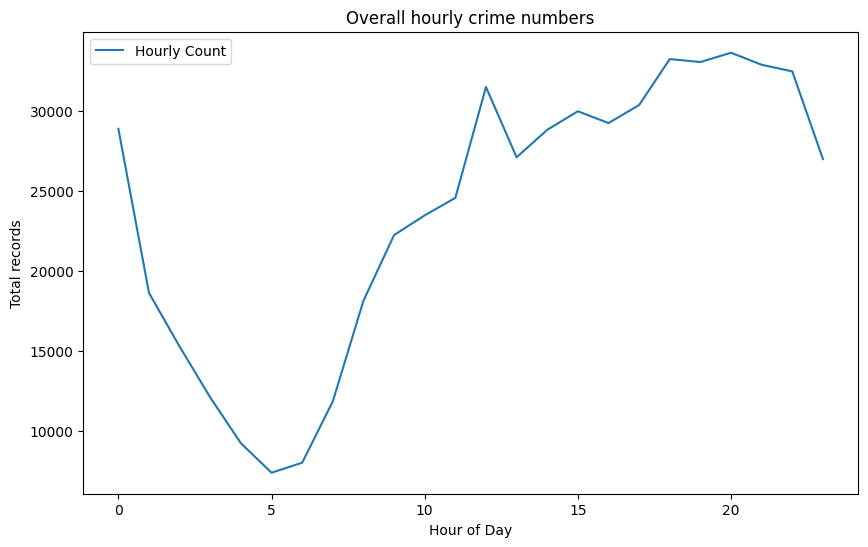

In [38]:
fig, ax = plt.subplots()
ax.plot(hourly_total_count_pddf['hour'], hourly_total_count_pddf['sum(count)'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
ax.legend()

Il semble que c'est plus agité entre 18h et 22h... avec un pic à midi.

Regardons le détail de chaque type de crime.



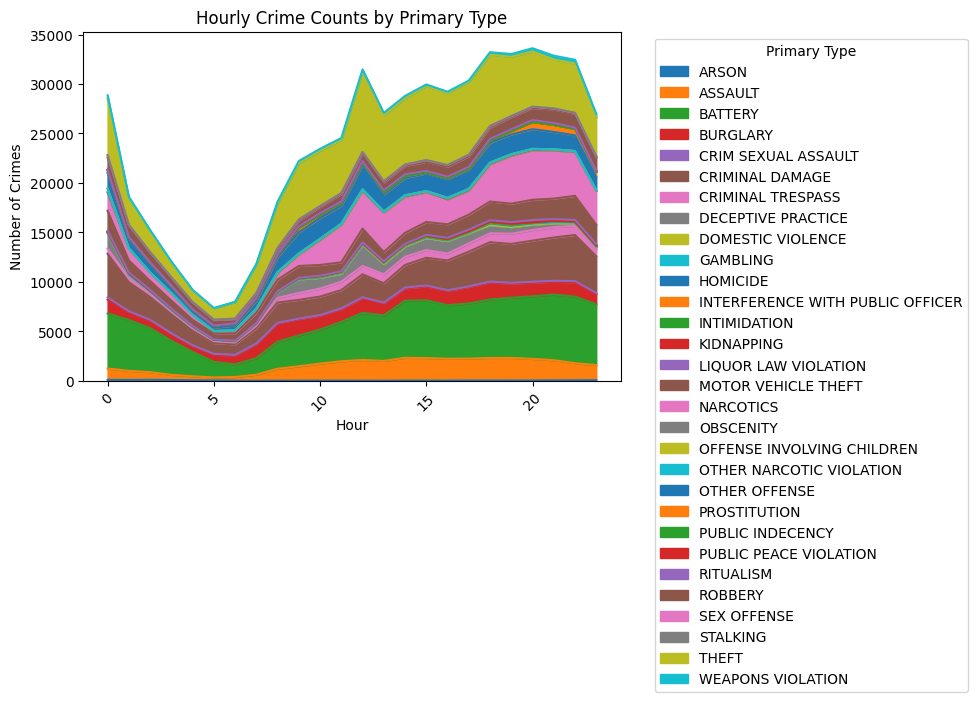

In [39]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Group data by hour and primary type and sum the counts
hourly_counts_grouped = hourly_count_pddf.groupby(['hour', 'primary_type'])['count'].sum().unstack()

# Plot stacked area chart
hourly_counts_grouped.plot(kind='area', stacked=True, ax=plt.gca())

plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.title('Hourly Crime Counts by Primary Type')
plt.xticks(rotation=45)
plt.legend(title='Primary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Dans que type d'endroit les crimes sont commis ?

Le dataset indique la "classe" de lieu où le crime a été commis : maison, rue, etc. Regardons ça en détails.

In [40]:
# Combien de types d'endroit sont recensés
df.select('location_description').distinct().count()

114

Ok, il y a 114 types différents d'endroit qui sont recensés.

Quels sont les 10 endroits les plus fréquents ?

In [41]:
df.groupBy(['location_description']).count().orderBy('count', ascending=False).show(10, truncate=False)

+------------------------------+------+
|location_description          |count |
+------------------------------+------+
|STREET                        |175545|
|RESIDENCE                     |111318|
|APARTMENT                     |33317 |
|SIDEWALK                      |33153 |
|OTHER                         |24645 |
|PARKING LOT/GARAGE(NON.RESID.)|18938 |
|SCHOOL, PUBLIC, BUILDING      |12615 |
|ALLEY                         |12081 |
|RESIDENCE-GARAGE              |11750 |
|RESIDENCE PORCH/HALLWAY       |10383 |
+------------------------------+------+
only showing top 10 rows



### Crimes "domestiques" :

En dehors de la localité, le dataset indique aussi s'il s'agit d'une violence domestique (dispute familiale, harcélement, etc.) ou pas.

Regardons ces types de violence plus en détails :

In [42]:
domestic_hour = df_hour.groupBy(['domestic', 'hour']).count().orderBy('hour').toPandas()

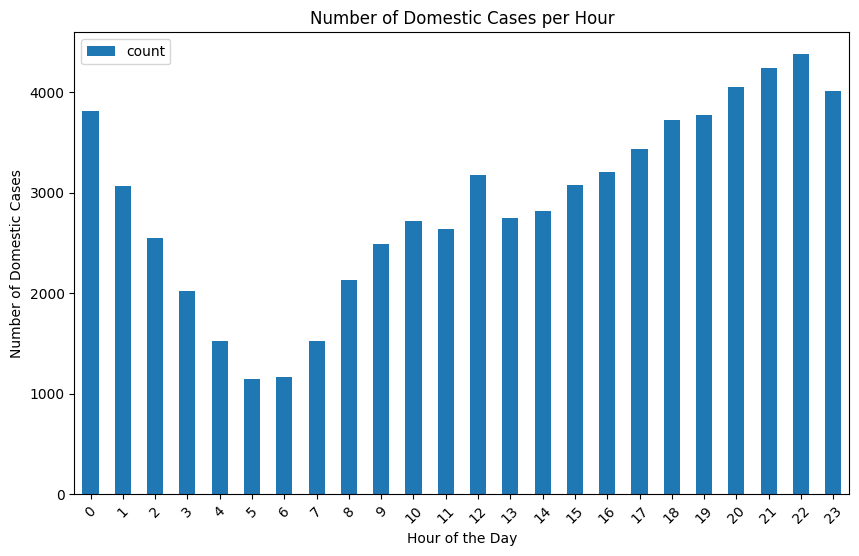

In [43]:
import matplotlib.pyplot as plt

# Filter for domestic cases
domestic_cases = df_hour.filter(df_hour['domestic'] == True)

# Group by hour and count
domestic_cases_by_hour = domestic_cases.groupBy('hour').count().orderBy('hour').toPandas()

# Create the bar plot
#plt.figure(figsize=(8, 4))
domestic_cases_by_hour.plot(kind='bar', x='hour', y='count', ax=plt.gca())
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Domestic Cases')
plt.title('Number of Domestic Cases per Hour')
plt.xticks(rotation=45)
plt.show()


Il y a une montée des violences domestiques le soir, avec un pic isolé à midi (disputes pendant le repas ?)

Et comment ça se situe par rapport aux crimes/violences "non-domestiques" ?

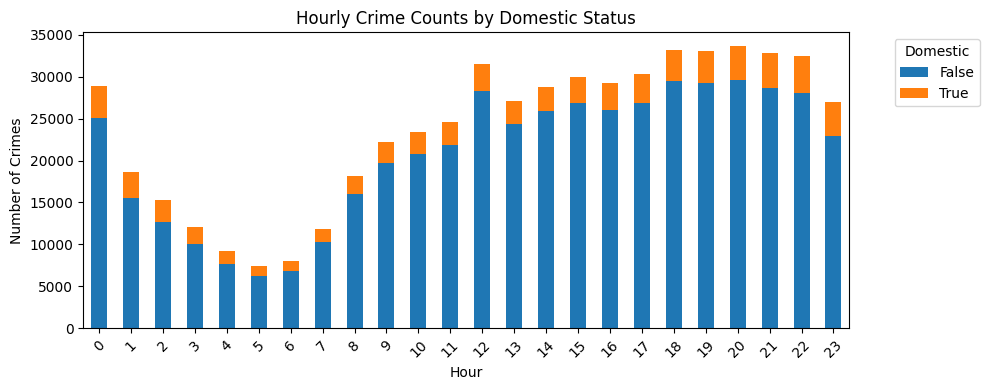

In [45]:
import matplotlib.pyplot as plt
# Create the plot
plt.figure(figsize=(10, 4))

# Group data by hour and domestic status and sum the counts
domestic_counts_grouped = domestic_hour.groupby(['hour', 'domestic'])['count'].sum().unstack()

# Plot stacked bar chart
domestic_counts_grouped.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.title('Hourly Crime Counts by Domestic Status')
plt.xticks(rotation=45)
plt.legend(title='Domestic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Une analyse par rapport au temps

Les données de type heure/date permettent d'obtenir plus d'information sur les types de crime et d'émettre des hypothèses sur leurs sursauts. Par ontre, d'autres facteurs externes comme le changement de garde ou les nouvelles politiques de sécurité peuvent avoir un impact non décrit ici.

Néanmoins, si on a une idée de quand et où les crimes sont les plus fréquents, on peut s'aventurer à faire quelques prévisions...

On va rajouter quelques champs utiles :

 * l'heure du jour (déjà présent dans le champ 'hour')
 * le jour de la semaine (dimanche = 1, ..., samedi = 7)
 * le mois de l'année
 * le "numéro du jour" dans une séquence 1, 2...(on commence à compter à partir du 2001-01-01).

In [47]:
from pyspark.sql.functions import dayofweek, month, dayofmonth, datediff, to_date, lit

df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [48]:
df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(10, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|01/01/2001 11:00:00 AM|2001-01-01|11  |2       |2001|1         |1        |0          |
|01/01/2001 12:00:00 AM|2001-01-01|0   |2       |2001|1         |1        |0          |
|01/01/2001 12:00:00 AM|2001-01-01|0   |2       |2001|1         |1        |0          |
|06/16/2001 08:00:00 AM|2001-06-01|8   |7       |2001|6         |16       |166        |
|06/01/2001 08:00:00 AM|2001-06-01|8   |6       |2001|6         |1        |151        |
|07/25/2001 10:00:00 AM|2001-07-01|10  |4       |2001|7         |25       |205        |
|06/23/2001 08:00:00 PM|2001-06-01|20  |7       |2001|6         |23       |173        |
|01/01/2001 12:00:00 AM|2001-01-01|0   |2       |2001|1         |1        |0          |
|05/01/2001 12:01:00 AM|2001-05-

## Les crimes par rapport au jour de la semaine


In [49]:
week_day_crime_counts = df_dates.groupBy('week_day').count()

In [50]:
week_day_crime_counts_pddf = week_day_crime_counts.orderBy('week_day').toPandas()

<Axes: xlabel='week_day'>

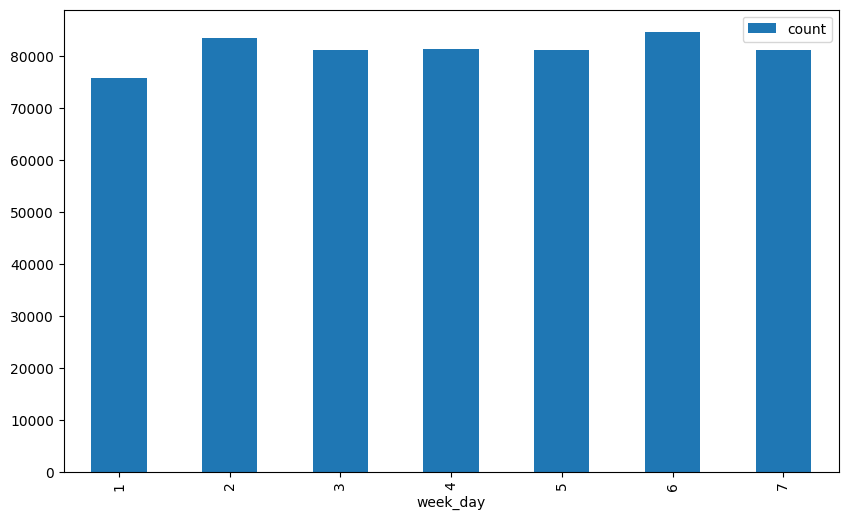

In [51]:
week_day_crime_counts_pddf.plot(kind='bar', x='week_day', y='count')

On voit très peu de variance... D'un autre côté, les criminels restent "méchants" tous les jours. Et probablemnt il y a des crimes le dimanche qui ne sont signalés que le lundi !

## Mois de l'année



In [52]:
year_month_crime_counts = df_dates.groupBy('year_month').count()

In [53]:
year_month_crime_counts_pddf = year_month_crime_counts.orderBy('year_month').toPandas()

Il semble que la période Mai-Août est la plus active pour les criminels. Des idées sur la cause ?


<Axes: xlabel='year_month'>

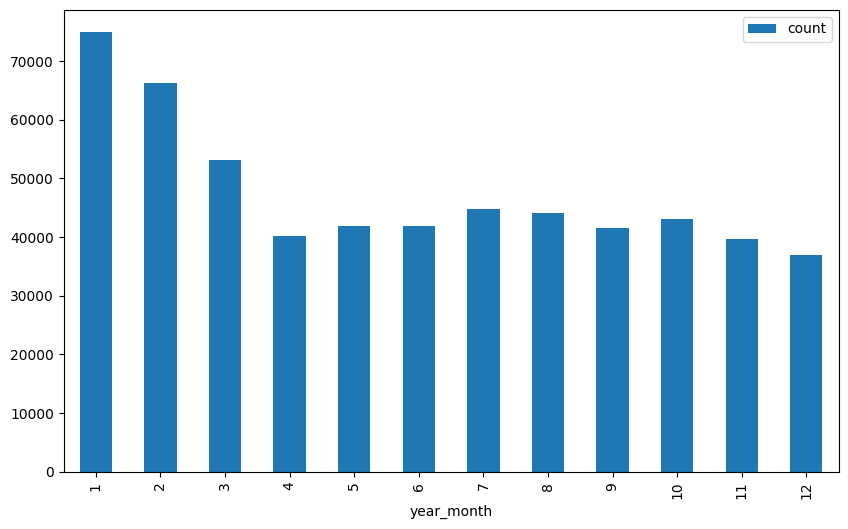

In [54]:
year_month_crime_counts_pddf.plot(y='count', x='year_month', kind='bar')

AH, ça c'est intéressant ! On a beaucoup de crimes en janvier et février. Serait-ça lié à la déprim de l'hiver ? Regardons rapidement si ça a un impact sur les violences domestiques.

In [55]:
domestic_month = df_dates.groupBy('domestic','year_month').count().orderBy('year_month').toPandas()

In [56]:
domestic_month = domestic_month[domestic_month['domestic'] == True]

In [75]:
year_month_crime_counts_pddf['domestic_count']=domestic_month['count']
year_month_crime_counts_pddf['domestic_percent'] = domestic_month['count']/year_month_crime_counts_pddf['count']

<Axes: xlabel='year_month'>

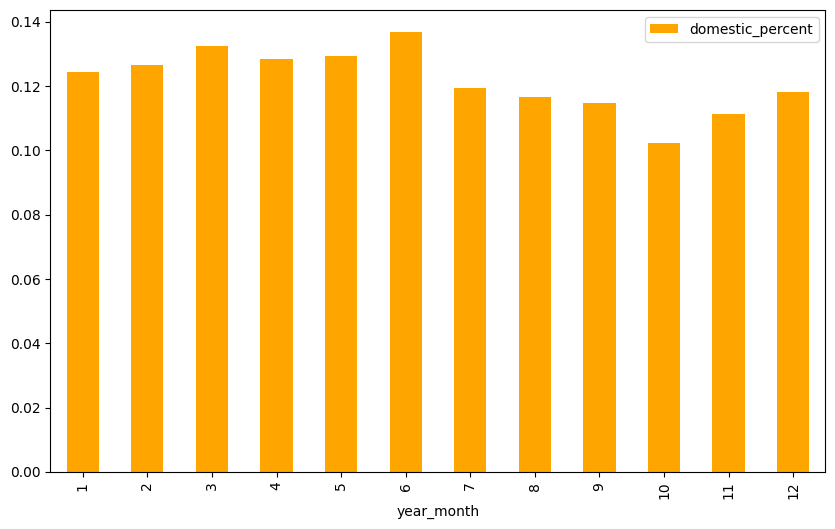

In [77]:
year_month_crime_counts_pddf.plot(x='year_month', y='domestic_percent', kind='bar', color='orange')

Bien que les mois d'hiver présentent un taux élevé de violences domestiques, le "blues de l'hiver" ne semble pas avoir une influence si grande que ça. 😯

---


# Pouvons-nous prédire la catégorie de crime (`primary_type`) à partir de quelques caractéristiques (domestique, avec violence), l'endroit (district, community_area), etc. ?

Afin de le faire, on va nettoyer un peu plus le dataset.

Tout d'abord, essayons de supprimer quelques colonnes qui ne sont pas intéressantes ou qui risquent d'influencer trop le dataset :

 * 'id'
 * 'case_number'
 * 'date' - déjà présent dans les autres données de date/heure
 * 'block' - trop précis, peut ajouter du "bruit"
 * 'iucr' - c'est juste un code pour le type de crime
 * 'x_coordinate' - trop précis, peut ajouter du "bruit"
 * 'y_coordinate' - trop précis, peut ajouter du "bruit"
 * 'year' - déjà présent dans les autres données de date/heure
 * 'updated_on' - pas utile
 * 'latitude' - trop précis, peut ajouter du "bruit"
 * 'longitude' - trop précis, peut ajouter du "bruit"
 * 'location' - non inclus
 * 'date_time' - trop précis, peut ajouter du "bruit"
 * 'description' - Supprimé. On trouvera l'équivalent dans `primary type`, qui est **notre objectif**

 On pourrait faire ça avec des `drop()`, mais faisons différemment : avec Spark nous avons la fonction `select()`, donc essayons de passer plutôt la liste de features qu'on veut garder :

 * 'location_description'
 * 'arrest'
 * 'domestic'
 * 'beat'
 * 'district'
 * 'ward'
 * 'community_area'
 * 'fbi_code'
 * 'hour'
 * 'week_day'
 * 'year_month'
 * 'month_day'
 * 'date_number'
 * 'primary_type'


In [115]:
selected_features = [
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'hour',
 'week_day',
 'year_month',
 'month_day',
 'date_number',
 'primary_type']

In [116]:
features_df = df_dates.select(selected_features)

Nous allons aussi identifier les types "uniques" pour les différents types de features (quels types de "location_description", quels types de "arrest"...). Ça sera utile pour la conversion des données catégoriques.

In [117]:
feature_level_count_dic = []

for feature in selected_features:
    print('Analysing %s' % feature)
    levels_list_df = features_df.select(feature).distinct()
    feature_level_count_dic.append({'feature': feature, 'level_count': levels_list_df.count()})


Analysing location_description
Analysing arrest
Analysing domestic
Analysing beat
Analysing district
Analysing ward
Analysing community_area
Analysing fbi_code
Analysing hour
Analysing week_day
Analysing year_month
Analysing month_day
Analysing date_number
Analysing primary_type


In [118]:
pnd.DataFrame(feature_level_count_dic).sort_values(by='level_count', ascending=False)

,feature,level_count
12,date_number,365
3,beat,286
0,location_description,114
6,community_area,78
5,ward,51
11,month_day,31
13,primary_type,30
7,fbi_code,25
8,hour,24
4,district,22


### Preparer le modèle

On fait un premier passage pour supprimer les "cases vides" :

In [119]:
df_dates_features = features_df.dropna(subset=selected_features)

In [120]:
df_dates_features.show(5)

+--------------------+------+--------+----+--------+----+--------------+--------+----+--------+----------+---------+-----------+--------------------+
|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|hour|week_day|year_month|month_day|date_number|        primary_type|
+--------------------+------+--------+----+--------+----+--------------+--------+----+--------+----------+---------+-----------+--------------------+
|           RESIDENCE|  true|    true| 531|     5.0| 9.0|          50.0|      02|  11|       2|         1|        1|          0| CRIM SEXUAL ASSAULT|
|           RESIDENCE|  true|   false| 813|     8.0|13.0|          62.0|      02|   0|       2|         1|        1|          0|OFFENSE INVOLVING...|
|               OTHER| false|   false| 913|     9.0|12.0|          59.0|      06|   0|       2|         1|        1|          0|               THEFT|
|           RESIDENCE|  true|   false| 726|     7.0|15.0|          67.0|      02|   8|       7|     

In [121]:
df_dates_features.printSchema()

root
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: integer (nullable = true)
 |-- district: double (nullable = true)
 |-- ward: double (nullable = true)
 |-- community_area: double (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- week_day: integer (nullable = true)
 |-- year_month: integer (nullable = true)
 |-- month_day: integer (nullable = true)
 |-- date_number: integer (nullable = true)
 |-- primary_type: string (nullable = true)



Les features retenues sont des **catégories**, donc nous devons passer par un encodeur pour les transformer en valeurs numériques.

Sur ScikitLearn on pourrait utiliser `OrdinalEncoder`ou `OneHotEncoder`, mais ça risque de ne pas fonctionner si on a beaucoup de données.

Spark offre ses propres versions d'encodeurs. Ici, nous voulons utiliser `StringIndexer`, un encodeur qui fonctionne comme OrdinalEncoder de sklearn.

Attention : StringIndexer ne reconnaît que les colonnes de format String (🙃). Il faudra transformer les colonnes *arrest* et *domestic* en string, car pour le moment elles sont de type booléen !

In [122]:
df_dates_features = df_dates_features.withColumn('arrest', df_dates_features['arrest'].cast('string'))
df_dates_features = df_dates_features.withColumn('domestic', df_dates_features['domestic'].cast('string'))

Là ça doit être bon !

Utilisons le string indexer de Spark pour transformer les catégories des features séléctionnées.

In [124]:
from pyspark.ml.feature import StringIndexer, VectorAssembler


In [125]:
for feature in feature_level_count_dic:
    indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature'])
    print('Fitting feature "%s"' % feature['feature'])
    model = indexer.fit(df_dates_features)
    print('Transforming "%s"' % feature['feature'])
    df_dates_features = model.transform(df_dates_features)

Fitting feature "location_description"
Transforming "location_description"
Fitting feature "arrest"
Transforming "arrest"
Fitting feature "domestic"
Transforming "domestic"
Fitting feature "beat"
Transforming "beat"
Fitting feature "district"
Transforming "district"
Fitting feature "ward"
Transforming "ward"
Fitting feature "community_area"
Transforming "community_area"
Fitting feature "fbi_code"
Transforming "fbi_code"
Fitting feature "hour"
Transforming "hour"
Fitting feature "week_day"
Transforming "week_day"
Fitting feature "year_month"
Transforming "year_month"
Fitting feature "month_day"
Transforming "month_day"
Fitting feature "date_number"
Transforming "date_number"
Fitting feature "primary_type"
Transforming "primary_type"


Comme on peut voir, on vient de créer plusieurs colonnes suppélentaires (suffixe _indexed) qui contiennent des valeurs numériques.

In [126]:
df_dates_features.show(5)

+--------------------+------+--------+----+--------+----+--------------+--------+----+--------+----------+---------+-----------+--------------------+----------------------------+--------------+----------------+------------+----------------+------------+----------------------+----------------+------------+----------------+------------------+-----------------+-------------------+--------------------+
|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|hour|week_day|year_month|month_day|date_number|        primary_type|location_description_indexed|arrest_indexed|domestic_indexed|beat_indexed|district_indexed|ward_indexed|community_area_indexed|fbi_code_indexed|hour_indexed|week_day_indexed|year_month_indexed|month_day_indexed|date_number_indexed|primary_type_indexed|
+--------------------+------+--------+----+--------+----+--------------+--------+----+--------+----------+---------+-----------+--------------------+----------------------------+--------------+---


Maintenant, on va vectoriser les éléments pour les avoir dans une colonne `features`. En effet, Spark n'utilise pas des Dataframe directement mais a besoin qu'on transforme les données en vecteurs.

In [127]:
indexed_features = ['%s_indexed' % fc['feature'] for fc in feature_level_count_dic]
indexed_features

['location_description_indexed',
 'arrest_indexed',
 'domestic_indexed',
 'beat_indexed',
 'district_indexed',
 'ward_indexed',
 'community_area_indexed',
 'fbi_code_indexed',
 'hour_indexed',
 'week_day_indexed',
 'year_month_indexed',
 'month_day_indexed',
 'date_number_indexed',
 'primary_type_indexed']

In [128]:
assembler = VectorAssembler(inputCols=indexed_features, outputCol='features')
vectorized_df_dates = assembler.transform(df_dates_features)

In [129]:
vectorized_df_dates.select('features').take(1)

[Row(features=DenseVector([0.0, 1.0, 1.0, 123.0, 13.0, 14.0, 57.0, 3.0, 17.0, 0.0, 0.0, 0.0, 0.0, 7.0]))]

### Et entraîner le modèle.

Utiliser une répartition **60%**/**40%** entre les données train et test.

Pour commencer, utilisons une régression logistique.
On peut voir l'ensemble de méthodes supportées par [Spark ici.](https://spark.apache.org/docs/latest/ml-classification-regression.html)

In [131]:
train, test = vectorized_df_dates.randomSplit([0.6, 0.4])

In [132]:
from pyspark.ml.classification import LogisticRegression

In [133]:
logisticRegression = LogisticRegression(labelCol='primary_type_indexed', featuresCol='features', maxIter=10, family='multinomial')

In [134]:
fittedModel = logisticRegression.fit(train)

## Quelle est la performance du modèle ?

In [135]:
fittedModel.summary.accuracy

0.8629543181060353

#### Est-ce que ça semble un bon modèle pour prédire les crimes ?

## À vous:

 * Exécuter le modèle sur l'ensemble de test

In [162]:
predictions = fittedModel.transform(test)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="primary_type_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy on test data = {accuracy}")

Accuracy on test data = 0.8395540475036355


On a environ 83% d'accuracy. Ceci dit, sur 30 catégories de `primary_index`, il y a certaines qui doivent être très bien prédites et d'autres pas.